# Hyperparameter tuning

In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

In [108]:
data = pd.read_csv('../../datasets/data-stemmed-R.csv')
Y = data['engagement.rate']
X = data.drop(columns=['engagement.rate'])
columns_to_scale= [col for col in X.columns if col not in X.select_dtypes('bool').columns.tolist()]
scaler = StandardScaler()
X[columns_to_scale]= scaler.fit_transform(X[columns_to_scale]) 

**DISCLAIMER:** we want a robust result about the optimal hyperparameters, so we are going to implement a CV. 
Since our future models will be trained in training sets with size $\frac{9}{10}|D|$, we can do hyperparameter tuning with CV on the entire dataset (in order to mantain the same proportion)

# Decision tree

In [170]:
param_grid = {'min_samples_split': [2, 11, 16, 26,31, 51, 101, 151, 201,501]}
# Create RegressorTree
dt = DecisionTreeRegressor()

# Use GridSearchCV to find the best hyperparameters
dt_grid_search = GridSearchCV(dt, param_grid, cv=10, scoring="neg_mean_absolute_error")
dt_grid_search.fit(X, Y)

# Print the best hyperparameters
dt_best_params = dt_grid_search.best_params_

In [171]:
print(f"Decision trees Best hyperparameters: {dt_best_params}")

Decision trees Best hyperparameters: {'min_samples_split': 101}


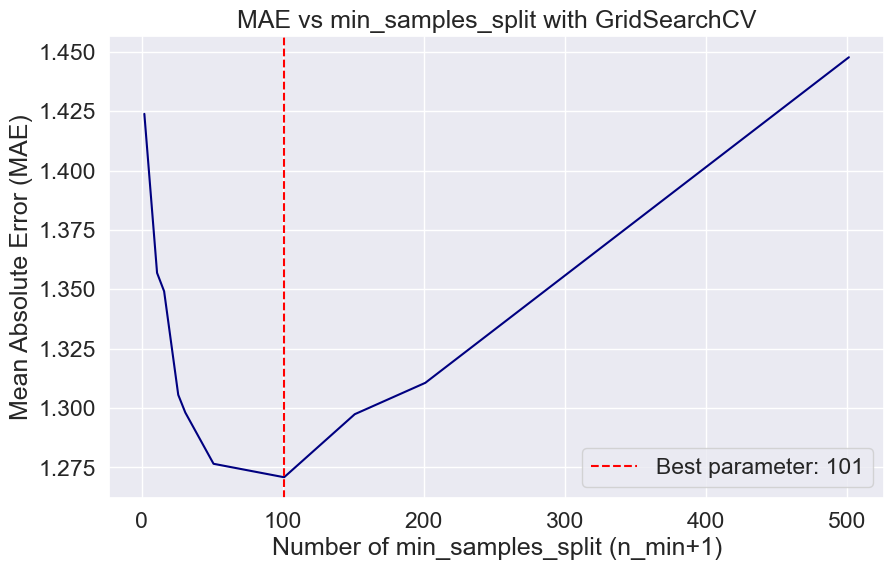

In [172]:
# Get the results in a DataFrame
dt_results = pd.DataFrame(dt_grid_search.cv_results_)

# Plot MAE vs n_neighbors using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=dt_results['param_min_samples_split'], y=-dt_results['mean_test_score'],color='navy')

# Highlight the best parameter
dt_best_param = dt_grid_search.best_params_['min_samples_split']
plt.axvline(x=best_param, color='red', linestyle='--', label=f'Best parameter: {dt_best_param}')

# Add labels and title
plt.xlabel('Number of min_samples_split (n_min+1)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs min_samples_split with GridSearchCV')
plt.legend(loc='lower right')

# Show the plot
plt.show()

# Knn

In [173]:
# Define the range of neighbors
param_grid = {'n_neighbors': [1, 2, 5, 10, 15, 20, 50, 100]}

# Create KNeighborsRegressor
knn = KNeighborsRegressor()

# Use GridSearchCV to find the best hyperparameters
knn_grid_search = GridSearchCV(knn, param_grid, cv=10, scoring="neg_mean_absolute_error")
knn_grid_search.fit(X, Y)

# Print the best hyperparameters
knn_best_params = knn_grid_search.best_params_

In [163]:
print(f"KNN Best hyperparameters: {knn_best_params}")

KNN Best hyperparameters: {'n_neighbors': 50}


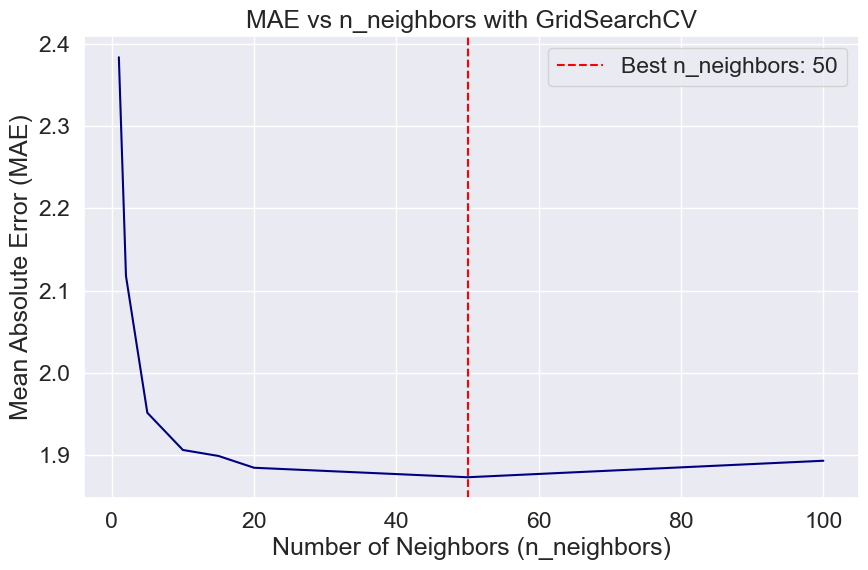

In [174]:
# Get the results in a DataFrame
knn_results = pd.DataFrame(grid_search.cv_results_)

# Plot MAE vs n_neighbors using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=knn_results['param_n_neighbors'], y=-knn_results['mean_test_score'],color='navy')

# Highlight the best parameter
knn_best_param = knn_grid_search.best_params_['n_neighbors']
plt.axvline(x=knn_best_param, color='red', linestyle='--', label=f'Best n_neighbors: {knn_best_param}')

# Add labels and title
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs n_neighbors with GridSearchCV')
plt.legend()

# Show the plot
plt.show()

# Random Forest

In [177]:
n_estimators= [100, 250, 500]
min_samples_split= [2, 11, 26, 51] #corrisponde a 1+n_min di medvet
max_features= [math.floor(math.sqrt(X.shape[1])), X.shape[1] // 3]

param_grid = {
    'n_estimators': n_estimators,
    'min_samples_split': min_samples_split,
    'max_features': max_features
}

# Create KNeighborsRegressor
rf = RandomForestRegressor()

# Use GridSearchCV to find the best hyperparameters
rf_grid_search = GridSearchCV(rf, param_grid, cv=10, scoring="neg_mean_absolute_error")
rf_grid_search.fit(X, Y)

# Print the best hyperparameters
rf_best_params = rf_grid_search.best_params_

In [178]:
print(f"Random forest Best hyperparameters: {rf_best_params}")

Random forest Best hyperparameters: {'max_features': 94, 'min_samples_split': 2, 'n_estimators': 500}


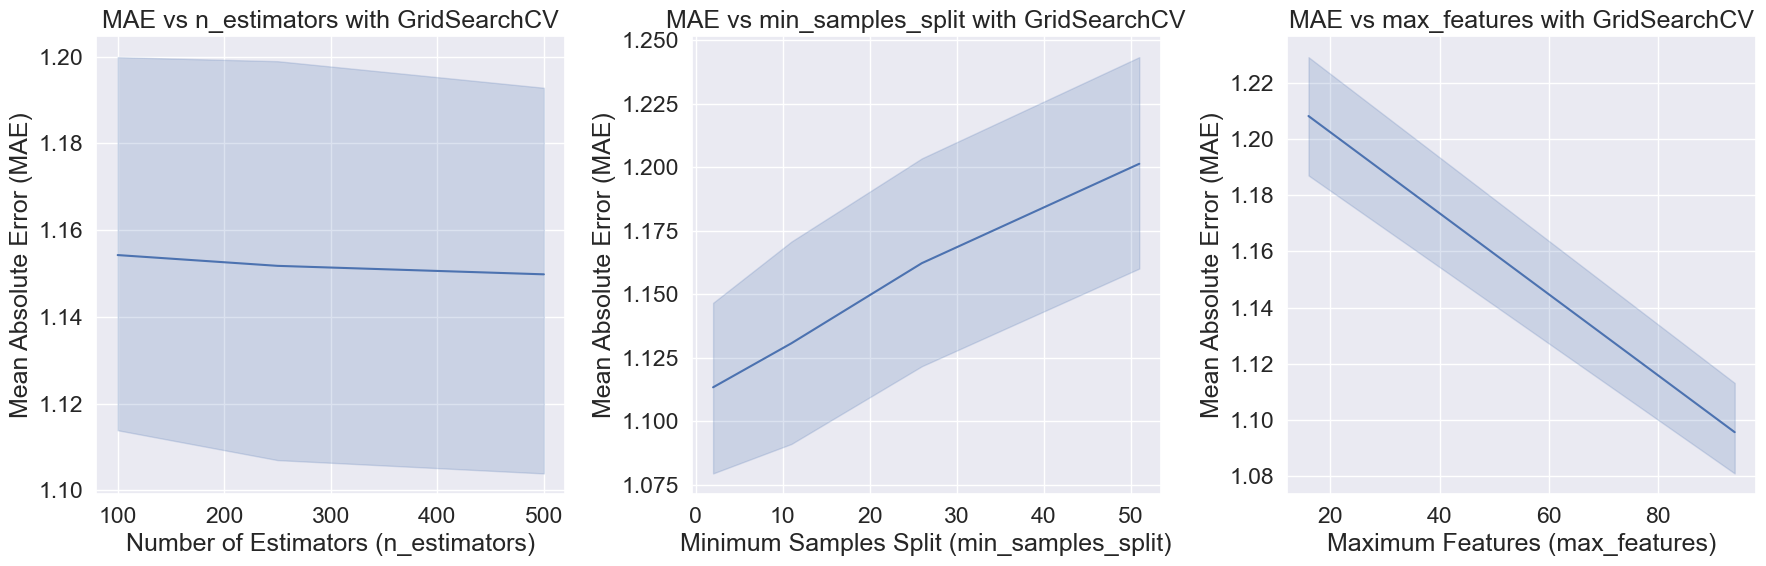

In [189]:
# Get the results in a DataFrame
rf_results = pd.DataFrame(rf_grid_search.cv_results_)

# Create a 1x3 matrix of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot MAE vs n_estimators
sns.lineplot(x='param_n_estimators', y=-rf_results['mean_test_score'], data=rf_results, ax=axes[0])
axes[0].set_xlabel('Number of Estimators (n_estimators)')
axes[0].set_ylabel('Mean Absolute Error (MAE)')
axes[0].set_title('MAE vs n_estimators with GridSearchCV')

# Plot MAE vs min_samples_split
sns.lineplot(x='param_min_samples_split', y=-rf_results['mean_test_score'], data=rf_results, ax=axes[1])
axes[1].set_xlabel('Minimum Samples Split (min_samples_split)')
axes[1].set_ylabel('Mean Absolute Error (MAE)')
axes[1].set_title('MAE vs min_samples_split with GridSearchCV')

# Plot MAE vs max_features
sns.lineplot(x='param_max_features', y=-rf_results['mean_test_score'], data=rf_results, ax=axes[2])
axes[2].set_xlabel('Maximum Features (max_features)')
axes[2].set_ylabel('Mean Absolute Error (MAE)')
axes[2].set_title('MAE vs max_features with GridSearchCV')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

TO DO: try to fix max features, and then see how number of estimators and min_split influence the MAE!

Explore also PPS

# SVR

In [75]:
param_grid = {'kernel': ['linear', 'poly', 'rbf']}

sv = SVR()

# Use GridSearchCV to find the best hyperparameters
sv_grid_search = GridSearchCV(sv, param_grid, cv=10, scoring="neg_mean_absolute_error")
sv_grid_search.fit(X, Y)

# Print the best hyperparameters
sv_best_params = sv_grid_search.best_params_

In [187]:
print(f"SVR best kernel: {sv_best_params}")

SVR best kernel: {'kernel': 'rbf'}
